In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

adj = pd.read_csv('adj.txt', header=None)
# make adj matrix
adj_matrix = np.zeros((len(adj),len(adj)))
for i in range(len(adj)):
    for j in range(len(adj)):
        if i == j:
            continue
        if str(j) in adj.iloc[i,0].split(' '):
            adj_matrix[i,j] = 1
            adj_matrix[j,i] = 1
# label            
label = np.loadtxt('karate_label.txt')

In [128]:
class LINE_first_negS:
    def __init__(self,
                 adj_matrix,
                 embedding_dim=2,
                 learning_rate=0.02,
                 num_negetive_sample=5):
        
        self.adj_matrix = adj_matrix
        self.embedding_dim = embedding_dim
        self.learning_rate = learning_rate
        self.k = num_negetive_sample
        self.whole_sampling_prob = np.power(np.sum(adj_matrix, axis=1), 3/4)
        self.w = np.random.rand(len(adj_matrix),embedding_dim)
        
        self.epoch_loss = 0.0

    def _sigmoid(self, a: float)-> float : 
        p = 1 / (1+np.exp(-a))
        return p

    def SGD_optim(self):
        self.epoch_loss = 0.0
        n = len(self.adj_matrix)
        total_iter = np.sum(adj_matrix) / 2
        for i in range(0,n):
            for j in range(i+1, n):
                if self.adj_matrix[i,j] == 1:
                    p1_pos = self._sigmoid(np.sum(self.w[i]*self.w[j]))
                    self.epoch_loss += - np.log(p1_pos) / total_iter
                    #여기서 i과 연결안된 node들 self.k개 sampling
                    neg_sample_idx = np.where(adj_matrix[i]==0)[0] # negative sample node's index
                    neg_sampling_prob = self.whole_sampling_prob[neg_sample_idx]
                    neg_samples = np.random.choice(a=neg_sample_idx, size=self.k, 
                                                   p=neg_sampling_prob/np.sum(neg_sampling_prob),
                                                   replace=False)
                    p1_negS_grad = np.zeros(self.embedding_dim)
                    for neg_idx in neg_samples:
                        self.epoch_loss += -np.log(self._sigmoid(-np.sum(self.w[i]*self.w[neg_idx]))+0.05) / total_iter
                        p1_negS_grad += self._sigmoid(np.sum(self.w[i]*self.w[neg_idx])) * self.w[neg_idx]
                    # update
                    self.w[i] -= self.learning_rate * (p1_pos-1)* self.w[j]
                    self.w[i] -= self.learning_rate * p1_negS_grad
                    self.w[j] -= self.learning_rate * (p1_pos-1) * self.w[i] 
        return self.epoch_loss
    
    def show_embedding(self):
        return self.w

Epoch = 10 : loss = 3.51865
Epoch = 20 : loss = 3.34341
Epoch = 30 : loss = 3.16902
Epoch = 40 : loss = 3.02871
Epoch = 50 : loss = 2.95138
Epoch = 60 : loss = 2.88714
Epoch = 70 : loss = 2.74873
Epoch = 80 : loss = 2.94135
Epoch = 90 : loss = 2.74900
Epoch = 100 : loss = 2.95777
Epoch = 110 : loss = 2.84907
Epoch = 120 : loss = 2.85203
Epoch = 130 : loss = 2.95471
Epoch = 140 : loss = 2.77772
Epoch = 150 : loss = 2.83944
Epoch = 160 : loss = 2.77902
Epoch = 170 : loss = 2.78139
Epoch = 180 : loss = 2.92064
Epoch = 190 : loss = 2.96892
Epoch = 200 : loss = 2.89679


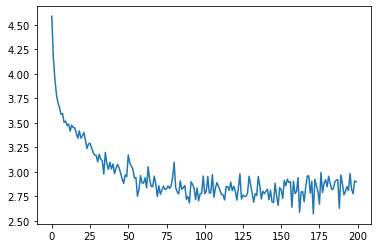

In [129]:
line_first_order = LINE_first_negS(adj_matrix, embedding_dim=2, learning_rate=0.02, num_negetive_sample=5)
epoch_losses = []

n_epochs = 200
for epoch in range(1, n_epochs+1):
    epoch_loss = line_first_order.SGD_optim()
    epoch_losses.append(epoch_loss)
    if epoch % 10 == 0:
        print(f'Epoch = {epoch} : loss = {epoch_loss:.5f}')
plt.plot(epoch_losses)
plt.show()

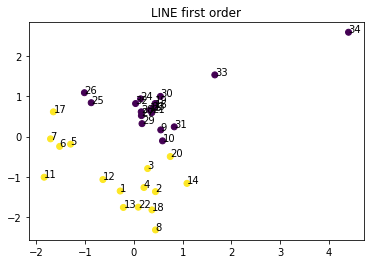

In [130]:
line_first_emb = line_first_order.show_embedding()

plt.title('LINE first order')
plt.scatter(line_first_emb[:,0],line_first_emb[:,1], c=list(map(int, label[:,1])))
for i in range(0, 34):
        plt.text(float(line_first_emb[i,0]), float(line_first_emb[i,1]), i+1 , fontsize=10)
plt.show()

In [190]:
class LINE_second_negS:
    def __init__(self,
                 adj_matrix,
                 embedding_dim=2,
                 learning_rate=0.02,
                 num_negetive_sample=5):
        
        self.adj_matrix = adj_matrix
        self.embedding_dim = embedding_dim
        self.learning_rate = learning_rate
        self.k = num_negetive_sample
        self.whole_sampling_prob = np.power(np.sum(adj_matrix, axis=1), 3/4)
        
        self.w = np.random.rand(len(adj_matrix),embedding_dim)
        self.w_context = np.random.rand(len(adj_matrix),embedding_dim)
        
        self.epoch_loss = 0.0

    def _softmax(self, a: np.array)-> np.array : 
        c = np.max(a) 
        exp_a = np.exp(a-c)
        sum_exp_a = np.sum(exp_a)
        y = exp_a / sum_exp_a
        return y

    def SGD_optim(self):
        self.epoch_loss = 0.0
        n = len(self.adj_matrix)
        total_iter = np.sum(adj_matrix)
        for i in range(0,n):
            for j in range(0, n):
                if self.adj_matrix[i,j] == 1:
                    # 여기서 i과 연결안된 node들 self.k개 sampling
                    neg_sample_idx = np.where(adj_matrix[i]==0)[0] # negative sample node's index
                    neg_sampling_prob = self.whole_sampling_prob[neg_sample_idx]
                    neg_samples = np.random.choice(a=neg_sample_idx, size=self.k, 
                                                   p=neg_sampling_prob/np.sum(neg_sampling_prob),
                                                   replace=False)
                    # 모든 context vector를 사용하지않고 negative sampling만 사용
                    # update
                    p2_j_given_i = np.exp(self.w[i] @ self.w_context[j]) \
                    / np.sum(np.exp(self.w_context[neg_samples] @ self.w[i]))
                    ## w gradient calculation
                    w_i_grad = (-self.w_context[j] +\
                                np.exp(self.w_context[neg_samples] @ self.w[i]) @ self.w_context[neg_samples]/\
                                np.sum(np.exp(self.w_context[neg_samples] @ self.w[i])))
                    ## context vector update
                    p2_j_given_i_vec = np.exp(self.w_context[neg_samples] @ self.w[i]) /\
                        np.sum(np.exp(self.w_context[neg_samples] @ self.w[i]))
                    self.w_context[neg_samples] -= self.learning_rate * np.diag(p2_j_given_i_vec) @ np.tile(self.w[i], self.k).reshape(self.k,-1)
                    self.w_context[j] -= self.learning_rate * (-(1-p2_j_given_i)*self.w[i])
                    ## w update
                    self.w[i] -= self.learning_rate * w_i_grad
                    ## loss
                    self.epoch_loss += - np.log(p2_j_given_i) / total_iter
        return self.epoch_loss
    
    def show_embedding(self):
        return self.w

Epoch = 100 : loss = 1.52307
Epoch = 200 : loss = 1.31369
Epoch = 300 : loss = 1.11173
Epoch = 400 : loss = 0.93085
Epoch = 500 : loss = 0.93106
Epoch = 600 : loss = 0.90281
Epoch = 700 : loss = 0.86403
Epoch = 800 : loss = 0.84997
Epoch = 900 : loss = 0.88377
Epoch = 1000 : loss = 0.87828


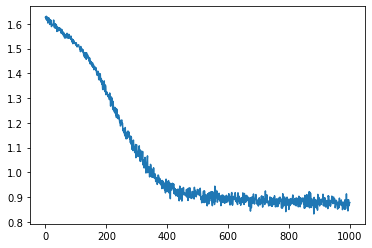

In [193]:
line_second_order = LINE_second_negS(adj_matrix, embedding_dim=2, learning_rate=0.002, num_negetive_sample=5)
epoch_losses = []

n_epochs = 1000
for epoch in range(1, n_epochs+1):
    epoch_loss = line_second_order.SGD_optim()
    epoch_losses.append(epoch_loss)
    if epoch % 100 == 0:
        print(f'Epoch = {epoch} : loss = {epoch_loss:.5f}')
plt.plot(epoch_losses)
plt.show()

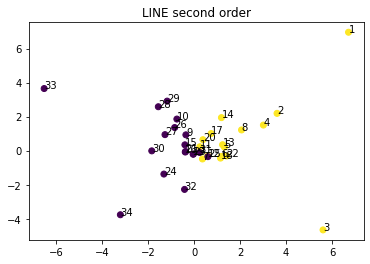

In [194]:
line_second_emb = line_second_order.show_embedding()

plt.title('LINE second order')
plt.scatter(line_second_emb[:,0],line_second_emb[:,1], c=list(map(int, label[:,1])))
for i in range(0, 34):
        plt.text(float(line_second_emb[i,0]), float(line_second_emb[i,1]), i+1 , fontsize=10)
plt.show()